In [14]:
%load_ext autoreload
%autoreload 2

from model_lighter import LitS4Model, LitS4DualModel
from data_20bins_lighter_fix import LitDataModule
from plotting import *
import torch
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import tqdm
import numpy as np
from models.networks import S4D_S4D_GatedModel, S4D_S4D_Model, S4DModel
import yaml
from scipy import signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
path = '/home/lfd34/project/project8/ssm/neutrino_project//runs/s4d_20bin_test_full_data/lightning_logs/pj7xpdqc/'
CHECKPOINT = os.path.join(path, 'checkpoints/last.ckpt')
image_folder = os.path.join(path, 'results')
config_path = os.path.join(path, "../../config.yaml")

In [22]:
! mkdir "{image_folder}"

In [23]:
with open(config_path) as config_file:
    config_data = yaml.safe_load(config_file)

if config_data['model']['class_path'] == 'model_lighter.LitS4Model':
    encoder_data = config_data['model']['init_args']['encoder']['init_args']
    encoder = S4DModel(
        d_input = encoder_data['d_input'],
        d_output = encoder_data['d_output'],
        d_model = encoder_data['d_model'],
        n_layers = encoder_data['n_layers'],
        dropout = encoder_data['dropout'],
        prenorm = encoder_data['prenorm'],
        fc_hidden = encoder_data['fc_hidden'],
        )
    model = LitS4Model.load_from_checkpoint(CHECKPOINT,
                encoder=encoder)

elif config_data['model']['class_path'] == 'model.LitS4DualModel':
    if config_data['model']['class_path']['encoder']['class_path'] == 'models.networks.S4D_S4D_GatedModel':
        encoder_data = config_data['model']['init_args']['encoder']['init_args']
        encoder = S4D_S4D_GatedModel(
            output_dim = encoder_data['output_dim'],
            d_input_ts = encoder_data['d_input_ts'],
            d_input_fft = encoder_data['d_input_fft'],
            s4d_ts_d_model = encoder_data['s4d_ts_d_model'],
            s4d_ts_n_layers = encoder_data['s4d_ts_n_layers'],
            s4d_ts_fc_hidden = encoder_data['s4d_ts_fc_hidden'],
            s4d_fft_d_model = encoder_data['s4d_fft_d_model'],
            s4d_fft_n_layers = encoder_data['s4d_fft_n_layers'],
            s4d_fft_fc_hidden = encoder_data['s4d_fft_fc_hidden'],
            combined_fc_hidden = encoder_data['combined_fc_hidden']    
            )
        model = LitS4DualModel.load_from_checkpoint(CHECKPOINT,
                encoder=encoder)
        
    elif config_data['model']['class_path']['encoder']['class_path'] == 'models.networks.S4D_S4D_Model':
        encoder_data = config_data['model']['init_args']['encoder']['init_args']
        encoder = S4D_S4D_Model(
            output_dim = encoder_data['output_dim'],
            d_input_ts = encoder_data['d_input_ts'],
            d_input_fft = encoder_data['d_input_fft'],
            s4d_ts_d_model = encoder_data['s4d_ts_d_model'],
            s4d_ts_n_layers = encoder_data['s4d_ts_n_layers'],
            s4d_ts_fc_hidden = encoder_data['s4d_ts_fc_hidden'],
            s4d_fft_d_model = encoder_data['s4d_fft_d_model'],
            s4d_fft_n_layers = encoder_data['s4d_fft_n_layers'],
            s4d_fft_fc_hidden = encoder_data['s4d_fft_fc_hidden'],
            combined_fc_hidden = encoder_data['combined_fc_hidden']    
            )
        model = LitS4DualModel.load_from_checkpoint(CHECKPOINT,
                encoder=encoder)

In [24]:
model = model.to(device)
model = model.eval()
dataset = LitDataModule.load_from_checkpoint(CHECKPOINT)

In [ ]:
true = []
pred = []
meta = []

max_powers = []
summed_powers = []

for ts,var,obs in dataset.test_dataloader():
    with torch.no_grad():
        pred.append(model(ts.to(device)).cpu().numpy())
        true.append(var.numpy())
        meta.append(obs.numpy())

        for i in range(ts.shape[0]):
            # Get the PSD for the "I" time series
            f_i, pxx_i = signal.periodogram(ts[i, :, 0].numpy(), fs=403E6)
            f_q, pxx_q = signal.periodogram(ts[i, :, 1].numpy(), fs=403E6)
            pxx_prod = pxx_i*pxx_i+pxx_q*pxx_q
            # Normalizing out the difference in noise power coming from std norm of time series
            noise_sum = np.sum(pxx_prod[:400]) # no signal in this region
            normed_pxx = pxx_prod/noise_sum
            max_powers.append(max(normed_pxx))
            summed_powers.append(np.sum(normed_pxx))

In [ ]:
#true = np.concatenate(true)
#pred = np.concatenate(pred)

true = np.concatenate(true, axis=0)
pred = np.concatenate(pred, axis=0)
meta = np.concatenate(meta, axis=0)

In [ ]:
# undo the normalization
pred_post = pred * dataset.stds + dataset.mu
true_post = true * dataset.stds + dataset.mu

In [ ]:
f = make_all_plots(dataset.variables, dataset.observables,true_post, pred_post, meta, folder=image_folder, savefigs=True)

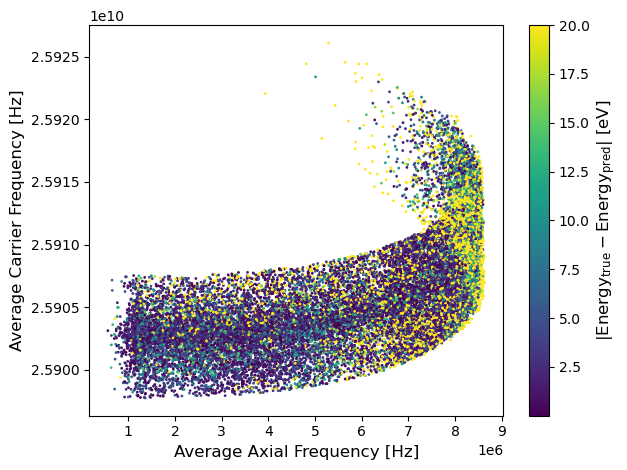

In [20]:
# true, pred: energy_eV, pitch_angle_deg
# meta: avg_axial_frequency_Hz, avg_carrier_frequency_Hz, radius_m

avg_axial_frequency_Hz = meta[:, 0]
avg_carrier_frequency_Hz = meta[:, 1]
true_energy = true_post[:, 0]
pred_energy = pred_post[:, 0]

fig, ax = plt.subplots()

sc = ax.scatter(
    avg_axial_frequency_Hz,
    avg_carrier_frequency_Hz,
    c=np.abs(true_energy - pred_energy),
    s=1,
    cmap='viridis', 
    vmax=20
)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label(r"$|\text{Energy}_{\text{true}} - \text{Energy}_{\text{pred}}|$ [eV]")

plt.xlabel("Average Axial Frequency [Hz]")
plt.ylabel("Average Carrier Frequency [Hz]")

plt.tight_layout()
plt.show()


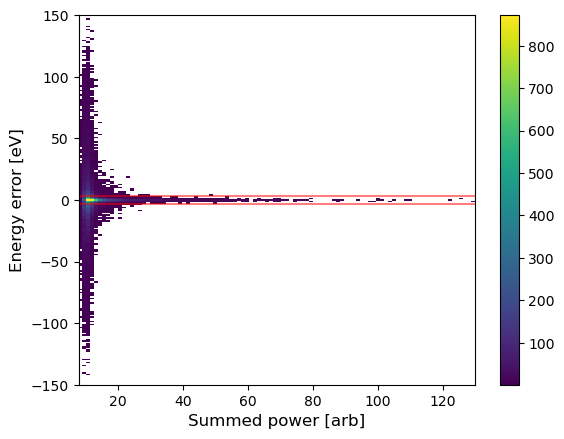

In [56]:
# plt.hist2d(summed_powers, true_energy - pred_energy, bins=100, cmin=1)
# plt.xlabel("Summed power [arb]")
# plt.ylabel("Energy error [eV]")
# plt.ylim(-20, 20)
# plt.axhline(-3, color='r')
# plt.axhline(3, color='r')

#mask = np.array(summed_powers) >  7.81763077

summed_powers = np.array(summed_powers)

h = plt.hist2d(summed_powers, (true_energy - pred_energy),
               bins=(100,250), cmin=1)

plt.xlabel("Summed power [arb]")
plt.ylabel("Energy error [eV]")
plt.ylim(-150, 150)

plt.axhline(-3, color='r', alpha = 0.5)
plt.axhline(3, color='r', alpha = 0.5)

plt.colorbar(h[3])

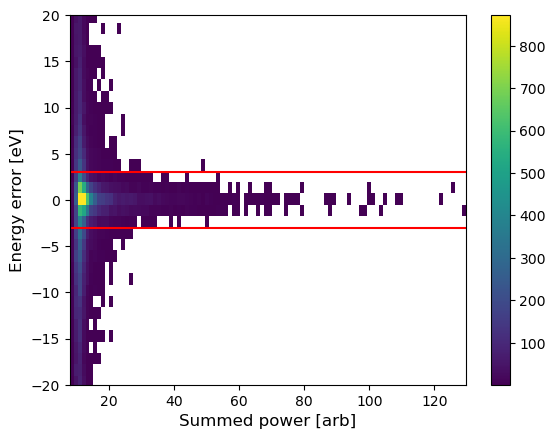

In [45]:
h = plt.hist2d(summed_powers, true_energy - pred_energy,
               bins=(100, 250), cmin=1)

plt.xlabel("Summed power [arb]")
plt.ylabel("Energy error [eV]")
plt.ylim(-20, 20)

plt.axhline(-3, color='r')
plt.axhline(3, color='r')

plt.colorbar(h[3])

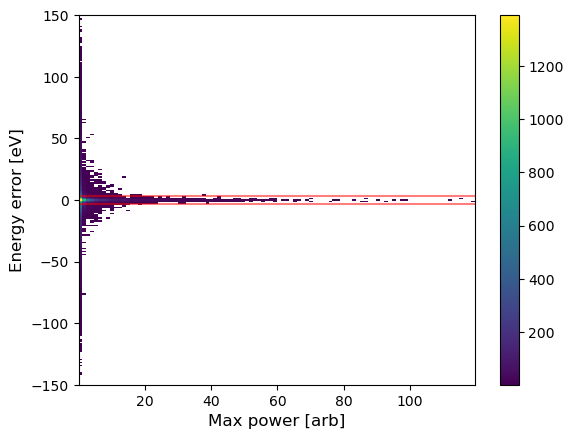

In [46]:
h = plt.hist2d(max_powers, true_energy - pred_energy,
               bins=(100, 250), cmin=1)

plt.xlabel("Max power [arb]")
plt.ylabel("Energy error [eV]")
plt.ylim(-150, 150)

plt.axhline(-3, color='r', alpha = 0.5)
plt.axhline(3, color='r', alpha = 0.5)

plt.colorbar(h[3])

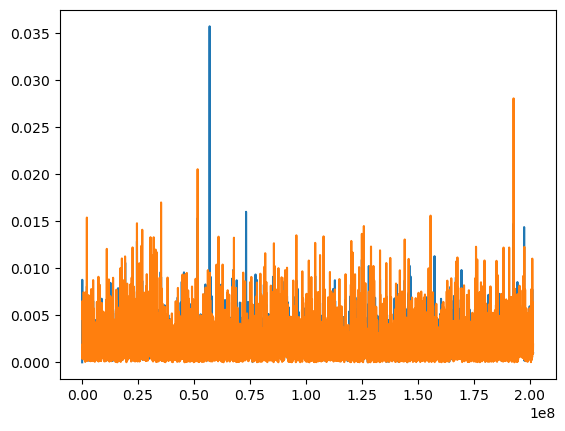

In [47]:
for ts, fft, var, _ in dataset.test_dataloader():
    for i in range(1):
        f_i, pxx_i = signal.periodogram(ts[i, :, 0].numpy(), fs=403E6)
        f_q, pxx_q = signal.periodogram(ts[i, :, 1].numpy(), fs=403E6)
        pxx_prod = pxx_i+pxx_q
        noise_sum = np.sum(pxx_prod[:400]) # no signal in this region
        normed_pxx = pxx_prod/noise_sum

        fft_i = fft[i, :, 0].numpy()
        fft_q = fft[i, :, 1].numpy()
        fft_i = fft_i[:4097]
        fft_q = fft_q[:4097]
        fft_prod = fft_i*fft_i + fft_q*fft_q
        noise_sum_fft = np.sum(fft_prod[:400])
        normed_pxx_fft = fft_prod/noise_sum_fft
        plt.plot(f_i, normed_pxx)
        plt.plot(f_i, normed_pxx_fft)
    break
#plt.yscale('log')
#plt.ylim(1E-10, 1E-5)

In [ ]:
# true, pred: energy_eV, pitch_angle_deg
# meta: avg_axial_frequency_Hz, avg_carrier_frequency_Hz, radius_m

pitch_angle_bins = np.linspace(88, 90, 100)
radius_bins = np.linspace(0, 0.007, 100)

true_pitch_angles = true_post[:,1]
true_radii = meta[:,2]
true_energies = true_post[:,0]
pred_energies = pred_post[:,0]
recon_mask = np.abs(true_energies - pred_energies) < 3

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(true_pitch_angles, bins=pitch_angle_bins, density=True, alpha = 0.5, label="All events")
ax[0].hist(true_pitch_angles[recon_mask], bins=pitch_angle_bins, density=True, alpha = 0.5, label="Recon error < 3 eV")
ax[0].legend()
ax[0].set_xlabel(r"Pitch Angle [$^\circ$]")
ax[0].set_ylabel("Probability Density")
ax[1].hist(true_radii, bins=radius_bins, density=True, alpha = 0.5, label="All events")
ax[1].hist(true_radii[recon_mask], bins=radius_bins, density=True, alpha = 0.5, label="Recon error < 3 eV")
ax[1].set_xlabel(r"Radius [m]")
ax[1].set_ylabel("Probability Density")
ax[1].legend()
plt.show()

In [10]:
sizes = np.array([4096,8192, 12000])
#ts_resolution_bias = np.array([-1.5275,-0.0072,-0.7850])
#ts_resolution_std = np.array([14.8861,10.4238,8.2875])
#fft_resolution_bias = np.array([1.6569,-3.7276,-2.9765])
fft_resolution_std = np.array([3.5120,1.4283, 1.2555])
#ts_and_fft_resolution_bias = np.array([-1.5514, 0.9063,-0.3050])
#ts_and_fft_resolution_std = np.array([10.5960,5.7198,5.2921])

# fig, ax = plt.subplots()
# ax.errorbar(
#     sizes, ts_resolution_bias, yerr=ts_resolution_std,
#     fmt='o-', color='tab:blue', ecolor='tab:blue', elinewidth=1.5, capsize=4,
#     label='Time Series', markersize=6, alpha=0.8
# )

# ax.errorbar(
#     sizes, fft_resolution_bias, yerr=fft_resolution_std,
#     fmt='o-', color='tab:orange', ecolor='tab:orange', elinewidth=1.5, capsize=4,
#     label='FFT', markersize=6, alpha=0.8
# )

# ax.errorbar(
#     sizes, ts_and_fft_resolution_bias, yerr=ts_and_fft_resolution_std,
#     fmt='o-', color='tab:green', ecolor='tab:green', elinewidth=1.5, capsize=4,
#     label='Time Series + FFT', markersize=6, alpha=0.8
# )

# ax.axhline(y=0, color='black')

# ax.set_xlabel("Track Length")
# ax.set_ylabel("Energy Resolution [eV]")
# ax.set_ylim(-18,18)
# ax.grid(True, linestyle='--', alpha=0.5)
# ax.legend()
# plt.tight_layout()
# plt.show()

In [11]:
from scipy.optimize import curve_fit

def linear(x, slope, intercept):
    return slope*x + intercept

(slope_fft, intercept_fft), _ = curve_fit(linear, sizes, fft_resolution_std)

# (slope_ts, intercept_ts), _ = curve_fit(linear, sizes, ts_resolution_std)

# (slope_ts_and_fft, intercept_ts_and_fft), _ = curve_fit(linear, sizes, ts_and_fft_resolution_std)

print(f"fft: slope = {slope_fft}, intersect = {intercept_fft}")
# print(f"ts: slope = {slope_ts}, intersect = {intercept_ts}")
# print(f"ts: slope = {slope_ts_and_fft}, intersect = {intercept_ts_and_fft}")

desired_res = 0.3 #eV
#print(f"expected number of points to resolution")
#print(f"ts: {(desired_res - intercept_ts)/slope_ts}, fft: {(desired_res - intercept_fft)/slope_fft}, both: {(desired_res - intercept_ts_and_fft)/slope_ts_and_fft}")

fft: slope = -0.00028829717338787195, intersect = 4.3993205824148784


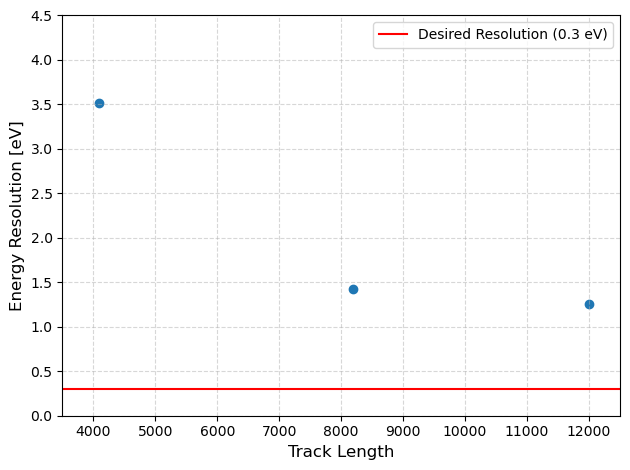

In [17]:
x_line = np.linspace(2000,15000, 1000)

fig, ax = plt.subplots()
#ax.scatter(sizes, ts_resolution_std, color='tab:blue', label="Time Series")
ax.scatter(sizes, fft_resolution_std)
#ax.scatter(sizes, ts_and_fft_resolution_std, color='tab:green', label="Time Series + FFT")
#ax.plot(x_line, linear(x_line, slope_ts, intercept_ts), ls="--", color='tab:blue')
#ax.plot(x_line, linear(x_line, slope_fft, intercept_fft), ls="--")
#ax.plot(x_line, linear(x_line, slope_ts_and_fft, intercept_ts_and_fft), ls="--", color='tab:green')
ax.axhline(y=0.3, color='r', label="Desired Resolution (0.3 eV)")
ax.set_xlabel("Track Length")
ax.set_ylabel("Energy Resolution [eV]")
ax.set_ylim(0,4.5)
ax.set_xlim(3500,12500)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()